<a href="https://colab.research.google.com/github/SINDHUSITA/Weather-Forecast/blob/main/Weather%20Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# PREDICTING FUTURE PRODUCT PRICES USING FACEBOOK PROPHET 



## Import Libraries and Dataset


In [ ]:
# import libraries 
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from fbprophet import Prophet

In [ ]:
# dataframes creation for both training and testing datasets 
dataset = pd.read_excel('Dataset.xlsx')


- Date: The date of the observation
- AveragePrice: the average price of a single avocado
- type: conventional or organic
- year: the year
- Region: the city or region of the observation
- Total Volume: Total number of avocados sold
- 4046: Total number of avocados with PLU 4046 sold
- 4225: Total number of avocados with PLU 4225 sold
- 4770: Total number of avocados with PLU 4770 sold

In [ ]:
dataset.head()

,YYYYMMDDHH,Temperaature (F),Windspeed (mph),% Sunshine (%),Precipitation (inch),Relative Humidity (%)
0,1985010100,39.38,2.237,2,0.035197,100
1,1985010101,39.20,2.237,1,0.056614,99
2,1985010102,39.20,6.711,1,0.033976,96
3,1985010103,36.86,11.185,2,0.017126,95
4,1985010104,34.70,11.185,4,0.005551,95


In [ ]:
dataset.tail()

,YYYYMMDDHH,Temperaature (F),Windspeed (mph),% Sunshine (%),Precipitation (inch),Relative Humidity (%)
280507,2016123119,25.34,4.474,99,0.0,90
280508,2016123120,24.26,4.474,99,0.0,91
280509,2016123121,23.54,2.237,100,0.0,91
280510,2016123122,23.18,2.237,100,0.0,90
280511,2016123123,23.00,2.237,100,0.0,89


In [ ]:
dataset.describe()

,YYYYMMDDHH,Temperaature (F),Windspeed (mph),% Sunshine (%),Precipitation (inch),Relative Humidity (%)
count,2.805120e+05,280512.000000,280512.000000,280512.000000,280512.000000,280512.000000
mean,2.000568e+09,51.909522,7.117236,51.004338,0.005099,75.654435
std,9.233206e+06,20.818163,4.159769,38.999307,0.027363,18.003322
min,1.985010e+09,-24.880000,0.000000,0.000000,0.000000,12.000000
25%,1.992788e+09,34.700000,4.474000,9.000000,0.000000,64.000000
50%,2.000567e+09,53.420000,6.711000,49.000000,0.000000,79.000000
75%,2.008345e+09,69.260000,8.948000,96.000000,0.000905,90.000000
max,2.016123e+09,107.960000,31.317000,100.000000,1.184604,136.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280512 entries, 0 to 280511
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YYYYMMDDHH             280512 non-null  int64  
 1   Temperaature (F)       280512 non-null  float64
 2   Windspeed (mph)        280512 non-null  float64
 3   % Sunshine (%)         280512 non-null  int64  
 4   Precipitation (inch)   280512 non-null  float64
 5   Relative Humidity (%)  280512 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 12.8 MB


In [ ]:
dataset.isnull().sum()

YYYYMMDDHH               0
Temperaature (F)         0
Windspeed (mph)          0
% Sunshine (%)           0
Precipitation (inch)     0
Relative Humidity (%)    0
dtype: int64

## Exploring Dataset 

In [ ]:
dataset = dataset.sort_values('YYYYMMDDHH')
dataset.head()

,YYYYMMDDHH,Temperaature (F),Windspeed (mph),% Sunshine (%),Precipitation (inch),Relative Humidity (%)
0,1985010100,39.38,2.237,2,0.035197,100
1,1985010101,39.20,2.237,1,0.056614,99
2,1985010102,39.20,6.711,1,0.033976,96
3,1985010103,36.86,11.185,2,0.017126,95
4,1985010104,34.70,11.185,4,0.005551,95


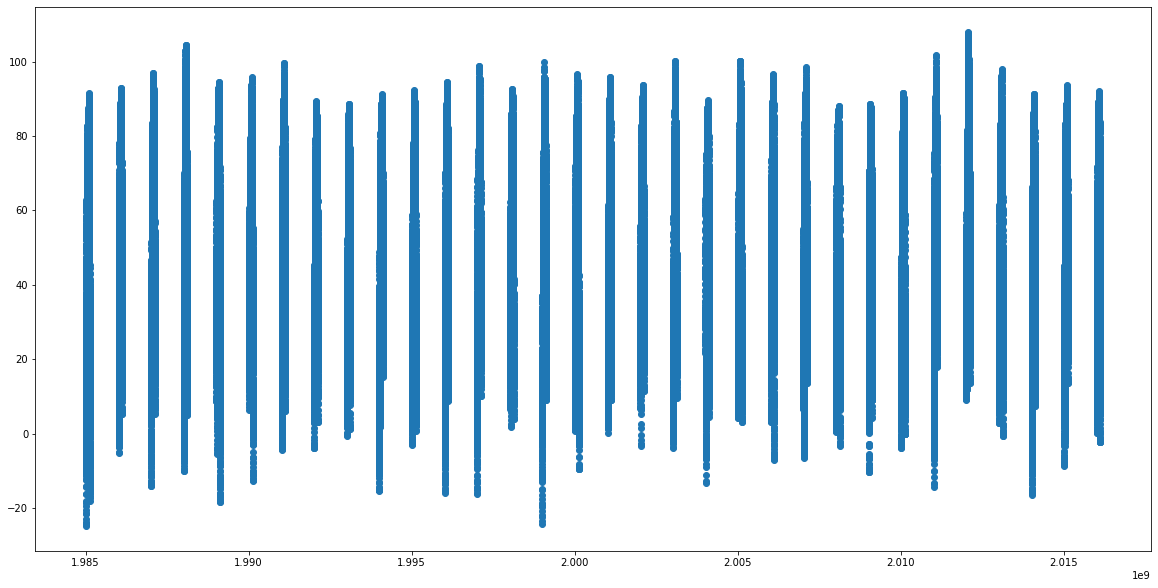

In [ ]:
# Plot date and average price
plt.figure(figsize = (20,10))
# plt.xticks(rotation=90)
plt.scatter(dataset['YYYYMMDDHH'],dataset['Temperaature (F)'])

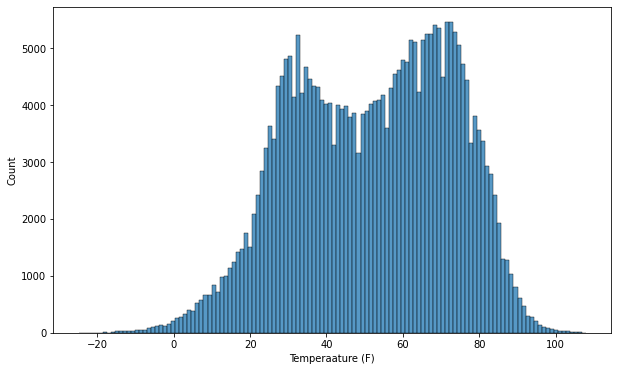

In [ ]:
# Plot distribution of the average price
plt.figure(figsize=(10,6))
sns.histplot(dataset['Temperaature (F)'])

## Preparing the data before applying Facebook Prophet tool

In [ ]:
data = dataset.iloc[:,0:2]
data.head()

,YYYYMMDDHH,Temperaature (F)
0,1985010100,39.38
1,1985010101,39.20
2,1985010102,39.20
3,1985010103,36.86
4,1985010104,34.70


In [ ]:
data = data.rename(columns = {'YYYYMMDDHH':'ds','Temperaature (F)':'y'})
data.head()

,ds,y
0,1985010100,39.38
1,1985010101,39.20
2,1985010102,39.20
3,1985010103,36.86
4,1985010104,34.70


In [ ]:
# date = data.iloc[0:5,0]
# for i in range(0, len(date)):
#   date[i] = str(date[i])
#   # date[i] = date[i][0:4] + '-' + date[i][4:6] + '-' + date[i][6:8] + ' ' + date[i][8:10] + ':00:00'
#   print(type(date[i]))
data['ds'] = data['ds'].map(str) 

In [ ]:
data.info()
data.ds = data.ds.str[0:4] + '-' + data.ds.str[4:6] + '-' + data.ds.str[6:8] + ' ' + data.ds.str[8:10] + ':00:00'
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280512 entries, 0 to 280511
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ds      280512 non-null  object 
 1   y       280512 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


,ds,y
0,1985-01-01 00:00:00,39.38
1,1985-01-01 01:00:00,39.20
2,1985-01-01 02:00:00,39.20
3,1985-01-01 03:00:00,36.86
4,1985-01-01 04:00:00,34.70


In [24]:
dataW = pd.concat([data["ds"], dataset["Windspeed (mph)"]], axis=1, keys=["ds", "y"])
dataS = pd.concat([data["ds"], dataset["% Sunshine (%)"]], axis=1, keys=["ds", "y"])
dataP = pd.concat([data["ds"], dataset["Precipitation (inch)"]], axis=1, keys=["ds", "y"])
dataR = pd.concat([data["ds"], dataset["Relative Humidity (%)"]], axis=1, keys=["ds", "y"])

## Developing Model and making predictions - PART A

In [19]:
m = Prophet(changepoint_prior_scale=0.01).fit(data)

In [25]:
mW = Prophet(changepoint_prior_scale=0.01).fit(dataW)

In [26]:
mS = Prophet(changepoint_prior_scale=0.01).fit(dataS)

In [27]:
mP = Prophet(changepoint_prior_scale=0.01).fit(dataP)

In [28]:
mR = Prophet(changepoint_prior_scale=0.01).fit(dataR)

In [ ]:
future = m.make_future_dataframe(periods=85000, freq='H')
fcst = m.predict(future)

In [ ]:
# Forcasting into the future
future = fb.make_future_dataframe(periods=365)
forecast = fb.predict(future)

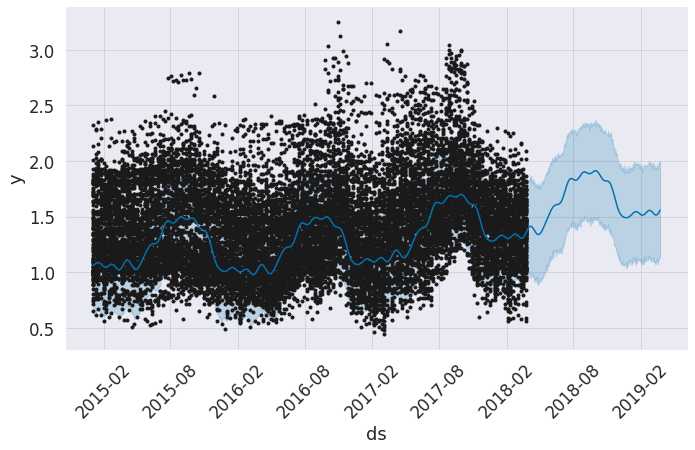

In [ ]:
figure = fb.plot(forecast)
# plt.figure(figsize=[25,12])
plt.xlabel="Year - Month"
plt.xticks(rotation = 45)
figure.show()

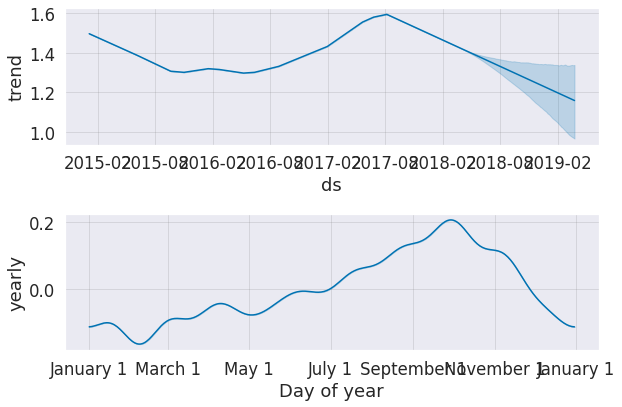

In [ ]:
figure2 = fb.plot_components(forecast)

## Developing Model and making Predictions (Region Specific) - PART B

In [ ]:
# dataframes creation for both training and testing datasets 
avocado_df = pd.read_csv('avocado.csv')

In [ ]:
# Selecting specific region
avocado_df_sample = avocado_df[avocado_df['region']=='West']

In [ ]:
avocado_df_sample = avocado_df_sample.sort_values('Date')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


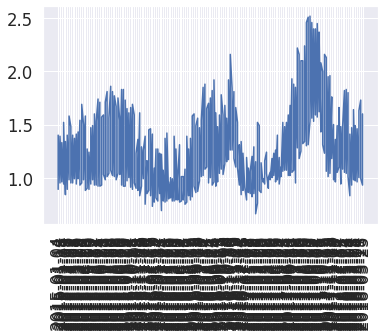

In [ ]:
plt.xticks(rotation=90)
plt.plot(avocado_df_sample['Date'],avocado_df_sample['AveragePrice'])

In [ ]:
avocado_df_sample = avocado_df_sample.rename(columns = {'Date':'ds','AveragePrice':'y'})

In [ ]:
m = Prophet()
m.fit(avocado_df_sample)
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


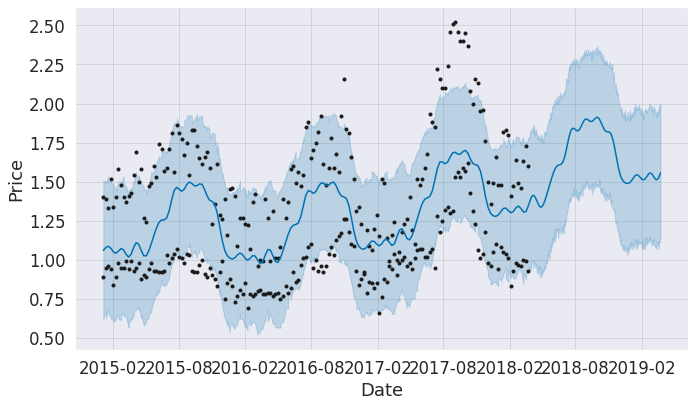

In [ ]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

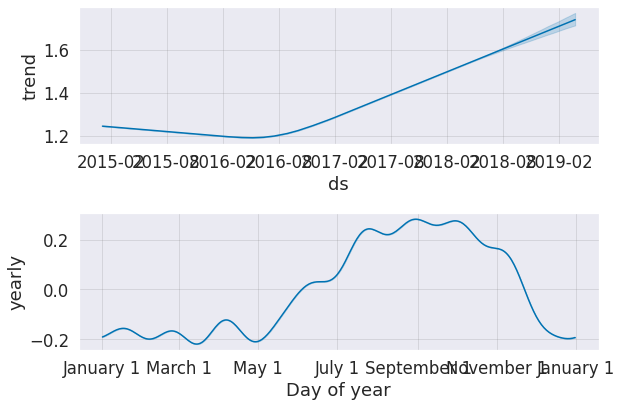

In [ ]:
figure3 = m.plot_components(forecast)

##END